In [1]:
from torch.utils.data import TensorDataset, random_split
from torchvision import datasets

train_dataset = datasets.MNIST('datasets/', train=True, download=True)
test_dataset = datasets.MNIST('datasets/', train=False, download=True)

train_dataset = TensorDataset(
    train_dataset.data,
    train_dataset.targets,
)
test_dataset = TensorDataset(
    test_dataset.data,
    test_dataset.targets,
)

train_dataset, val_dataset = random_split(train_dataset, [50000, 10000])

In [2]:
from PIL import Image
import os
import glob

def save_images(dataset, path_A, path_B):
    if os.path.exists(path_A) and os.path.exists(path_B):
        return

    os.makedirs(path_A)
    os.makedirs(path_B)

    def clear_directory(path):
        files = glob.glob(path + '*')
        for f in files:
            os.remove(f)
    clear_directory(path_A)
    clear_directory(path_B)

    images = [
        (Image.fromarray(image.numpy().astype('uint8')), int(label))
        for image, label in dataset
    ]
    images_by_label = {}
    for image, label in images:
        if label not in images_by_label:
            images_by_label[label] = []
        images_by_label[label].append(image)

    num_01 = min(len(images_by_label[0]), len(images_by_label[1]))
    num_23 = min(len(images_by_label[2]), len(images_by_label[3]))
    num_45 = min(len(images_by_label[4]), len(images_by_label[5]))
    num_67 = min(len(images_by_label[6]), len(images_by_label[7]))
    num_89 = min(len(images_by_label[8]), len(images_by_label[9]))

    start_index = 0
    for i in range(num_01):
        images_by_label[0][i].save(os.path.join(path_A, f'{start_index+i}.png'))
        images_by_label[1][i].save(os.path.join(path_B, f'{start_index+i}.png'))
    start_index += num_01
    for i in range(num_23):
        images_by_label[2][i].save(os.path.join(path_A, f'{start_index+i}.png'))
        images_by_label[3][i].save(os.path.join(path_B, f'{start_index+i}.png'))
    start_index += num_23
    for i in range(num_45):
        images_by_label[4][i].save(os.path.join(path_A, f'{start_index+i}.png'))
        images_by_label[5][i].save(os.path.join(path_B, f'{start_index+i}.png'))
    start_index += num_45
    for i in range(num_67):
        images_by_label[6][i].save(os.path.join(path_A, f'{start_index+i}.png'))
        images_by_label[7][i].save(os.path.join(path_B, f'{start_index+i}.png'))
    start_index += num_67
    for i in range(num_89):
        images_by_label[8][i].save(os.path.join(path_A, f'{start_index+i}.png'))
        images_by_label[9][i].save(os.path.join(path_B, f'{start_index+i}.png'))

save_images(train_dataset, 'datasets/mnist/A/train/', 'datasets/mnist/B/train/')
save_images(val_dataset, 'datasets/mnist/A/val/', 'datasets/mnist/B/val/')
save_images(test_dataset, 'datasets/mnist/A/test/', 'datasets/mnist/B/test/')

In [3]:
!python datasets/combine_A_and_B.py --fold_A datasets/mnist/A --fold_B datasets/mnist/B --fold_AB datasets/mnist/AB

[fold_A] =  datasets/mnist/A
[fold_B] =  datasets/mnist/B
[fold_AB] =  datasets/mnist/AB
[num_imgs] =  1000000
[use_AB] =  False
[no_multiprocessing] =  False
split = test, use 4814/4814 images
split = test, number of images = 4814
split = train, use 24179/24179 images
split = train, number of images = 24179
split = val, use 4856/4856 images
split = val, number of images = 4856


In [4]:
!python train.py --dataroot ./datasets/mnist/AB \
    --name mnist_pix2pix \
    --model pix2pix \
    --no_flip \
    --gpu_ids -1 \
    --display_id -1 \
    --save_latest_freq 100 \
    --print_freq 100 \
    --max_dataset_size 1000 \
    --n_epochs 30 \
    --n_epochs_decay 30

----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: ./datasets/mnist/AB           	[default: None]
             dataset_mode: aligned                       
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: -1                            	[default: 1]
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest                        
 

In [2]:
!python test.py --dataroot ./datasets/mnist/AB \
    --model pix2pix \
    --name mnist_pix2pix \
    --gpu_ids -1 \
    --num_test 10000 \
    --eval
    # --use_wandb \

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ./datasets/mnist/AB           	[default: None]
             dataset_mode: aligned                       
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: True                          	[default: False]
                  gpu_ids: -1                            	[default: 0]
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter:

In [7]:
def read_loss_log(loss_name):
    with open(f'checkpoints/mnist_pix2pix/latest_{loss_name}.log', 'r') as f:
        return [float(l.strip()) for l in f.readlines()]

train_losses_G_GAN = read_loss_log('train_loss_G_GAN')
train_losses_G_L1 = read_loss_log('train_loss_G_L1')
train_losses_G = [a + b for a, b in zip(train_losses_G_GAN, train_losses_G_L1)]
train_losses_D_real = read_loss_log('train_loss_D_real')
train_losses_D_fake = read_loss_log('train_loss_D_fake')
train_losses_D = [a + b for a, b in zip(train_losses_D_real, train_losses_D_fake)]
val_losses_G_GAN = read_loss_log('val_loss_G_GAN')
val_losses_G_L1 = read_loss_log('val_loss_G_L1')
val_losses_G = [a + b for a, b in zip(val_losses_G_GAN, val_losses_G_L1)]
val_losses_D_real = read_loss_log('val_loss_D_real')
val_losses_D_fake = read_loss_log('val_loss_D_fake')
val_losses_D = [a + b for a, b in zip(val_losses_D_real, val_losses_D_fake)]

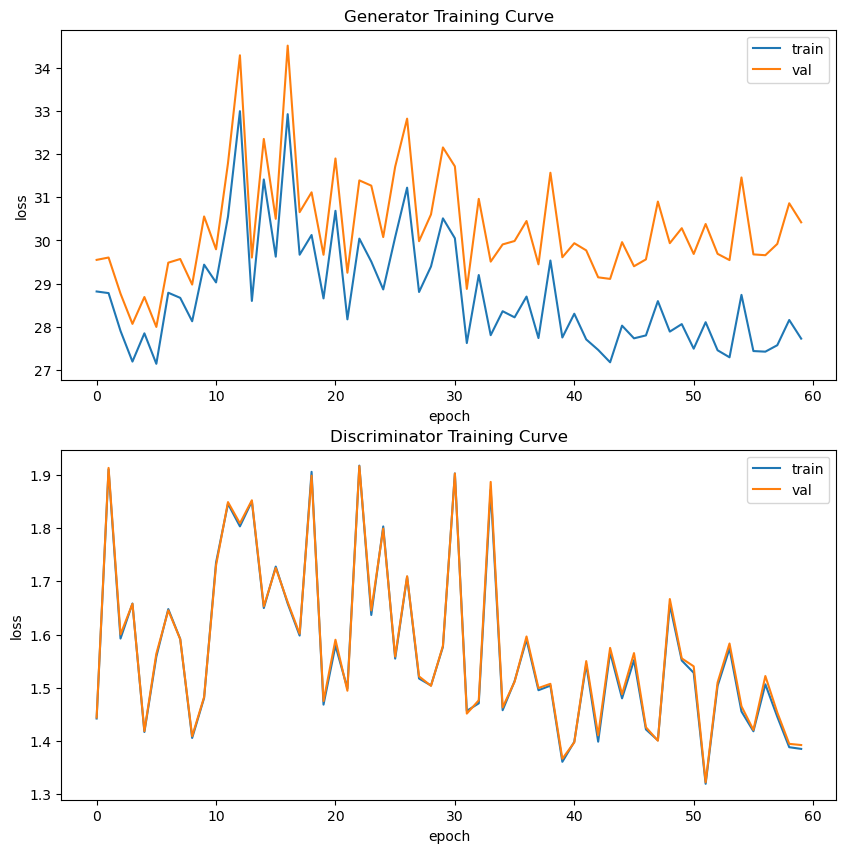

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(train_losses_G, label='train')
axs[0].plot(val_losses_G, label='val')
axs[0].set_title('Generator Training Curve')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')
axs[0].legend()

axs[1].plot(train_losses_D, label='train')
axs[1].plot(val_losses_D, label='val')
axs[1].set_title('Discriminator Training Curve')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('loss')
axs[1].legend()

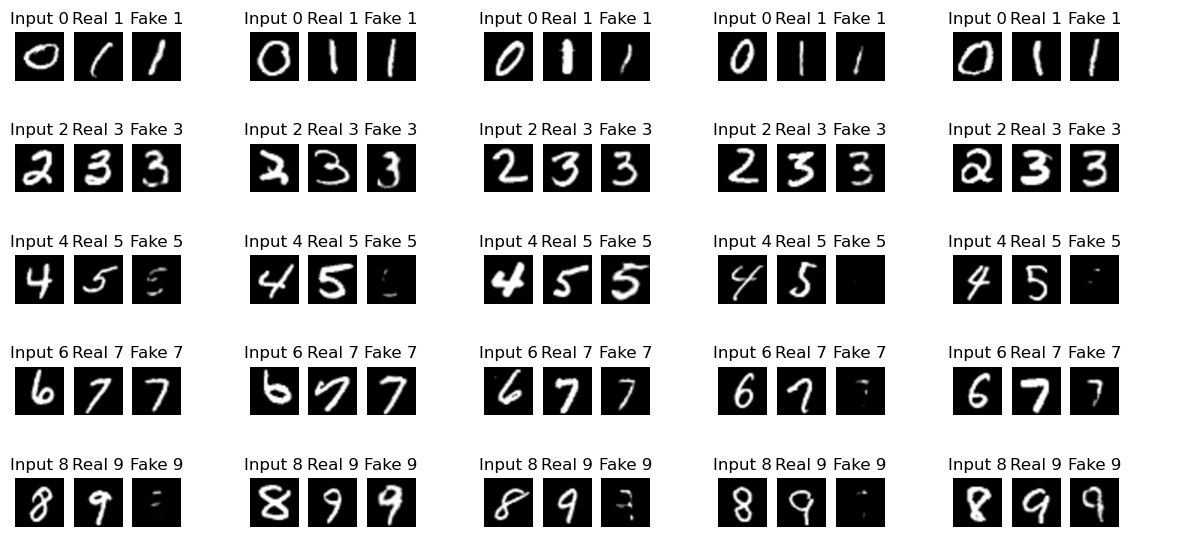

In [20]:
import numpy as np
from PIL import Image

results_01 = range(0, 980)
results_23 = range(980, 1990)
results_45 = range(1990, 2882)
results_67 = range(2882, 3840)
results_89 = range(3840, 4814)

fig, axs = plt.subplots(5, 20, figsize=(15, 7))

for i in range(5):
    if i == 0:
        results = results_01
    elif i == 1:
        results = results_23
    elif i == 2:
        results = results_45
    elif i == 3:
        results = results_67
    elif i == 4:
        results = results_89
    input_digit = i * 2
    output_digit = i * 2 + 1
    examples = np.random.choice(results, 5, replace=False)
    for j in range(5):
        real_A = Image.open(f'results/mnist_pix2pix/val_latest/images/{examples[j]}_real_A.png')
        real_B = Image.open(f'results/mnist_pix2pix/val_latest/images/{examples[j]}_real_B.png')
        fake_B = Image.open(f'results/mnist_pix2pix/val_latest/images/{examples[j]}_fake_B.png')
        axs[i, j*4].imshow(real_A)
        axs[i, j*4].axis('off')
        axs[i, j*4].set_title(f'Input {input_digit}')
        axs[i, j*4+1].imshow(real_B)
        axs[i, j*4+1].axis('off')
        axs[i, j*4+1].set_title(f'Real {output_digit}')
        axs[i, j*4+2].imshow(fake_B)
        axs[i, j*4+2].axis('off')
        axs[i, j*4+2].set_title(f'Fake {output_digit}')
        axs[i, j*4+3].axis('off')